# Visualize agent performance
In order to run this notebook, evaluate an agent on an environment using a `Runner` (see ![[../baselines/train_stable_dqn_baseline.py]]).

In [1]:
import json
from dataclasses import dataclass
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
@dataclass
class AgentMetrics:
    label: str
    returns: List[float]
    survival_duration: List[int]


def visualize_agent_survival(datasets: List[AgentMetrics]):
    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # --- Histogram + KDE per agent ---
    for data in datasets:
        sns.histplot(
            data.survival_duration,
            bins=20,
            kde=True,
            ax=axes[0],
            label=data.label,
            stat="density",
            element="step",
            fill=True
        )

    axes[0].set_title("Survival Duration Distribution (KDE + Histogram)")
    axes[0].set_xlabel("Time Steps")
    axes[0].set_ylabel("Density")
    axes[0].legend(title="Agent")

    # --- Single boxplot: one box per agent ---
    # Create dataframe: columns = ["Agent", "Survival Duration"]
    records = []
    for data in datasets:
        records.extend([{"Agent": data.label, "Survival Duration": d} for d in data.survival_duration])
    df = pd.DataFrame(records)

    sns.boxplot(
        data=df,
        x="Agent",
        y="Survival Duration",
        hue="Agent",
        ax=axes[1],
        palette="muted",
        legend=False
    )

    axes[1].set_title("Boxplot of Survival Durations per Agent")
    axes[1].set_xlabel("Agent")
    axes[1].set_ylabel("Time Steps")

    plt.tight_layout()
    plt.show()


def visualize_agent_survival_return_relationship(datasets: List[AgentMetrics]):
    plt.figure(figsize=(7.5, 5))
    for data in datasets:
        sns.scatterplot(
            x=data.survival_duration,
            y=data.returns,
            label=data.label
        )
    plt.title("Returns vs Survival Duration")
    plt.xlabel("Survival Duration (Time Steps)")
    plt.ylabel("Return")
    plt.legend()
    plt.show()


def get_evaluation_metrics(path, agent_name: str) -> List[AgentMetrics]:
    survival_duration = []
    returns = []
    for folder in path.iterdir():
        if folder.is_dir():
            with Path.joinpath(folder, "episode_meta.json").open() as f:
                episode_metadata = json.load(f)
                survival_duration.append(episode_metadata["nb_timestep_played"])
                returns.append(episode_metadata["cumulative_reward"])

    return AgentMetrics(agent_name, returns, survival_duration)


# Compare agent survival

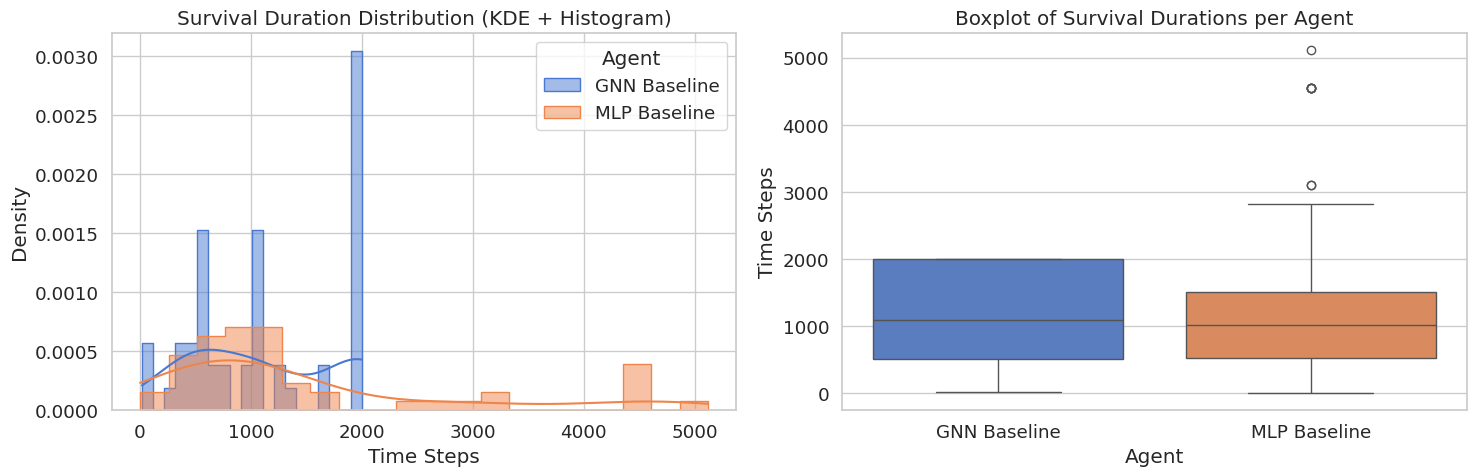

In [3]:
GNN_metrics = get_evaluation_metrics(Path("../data/evaluations/stable-baselines/dqn-gnn-baseline/train"), "GNN Baseline")
GNN_metrics2 = get_evaluation_metrics(Path("../data/evaluations/stable-baselines/dqn-mlp-baseline/train"), "MLP Baseline")
visualize_agent_survival([GNN_metrics, GNN_metrics2])

# Relation between reward and survival duration

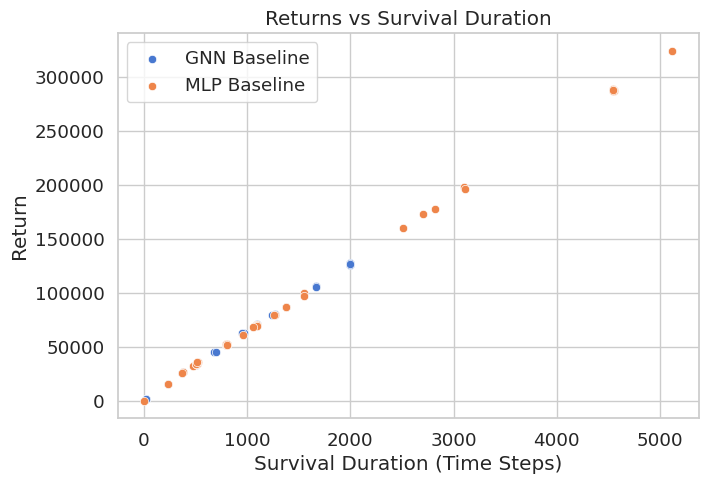

In [4]:
visualize_agent_survival_return_relationship([GNN_metrics, GNN_metrics2])